In [46]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import ast
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from collections import Counter

def metrics(filtered_actual, filtered_model):
    f1_class_op = f1_score(filtered_actual, filtered_model, labels=[0], average='macro')
    f1_class_su = f1_score(filtered_actual, filtered_model, labels=[1], average='macro')
    f1_class_nu = f1_score(filtered_actual, filtered_model, labels=[2], average='macro')
    weighted_f1 = f1_score(filtered_actual, filtered_model, average='weighted')
    accuracy = accuracy_score(filtered_actual, filtered_model)
    return f1_class_op, f1_class_su, f1_class_nu, weighted_f1, accuracy

def r3(df):
    # Apply rounding to each numeric value in the DataFrame
    df_rounded = df.applymap(lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x)
    return df_rounded

### reading the csv files

In [40]:
csv_dir = './res/test_total/Per_model_output'
csv_files = [f for f in os.listdir(csv_dir) if f.endswith('.csv')]

df_combined = pd.DataFrame()

for file in csv_files:
    file_path = os.path.join(csv_dir, file)
    df = pd.read_csv(file_path)
    df = df.drop('Unnamed: 0', axis=1)
    if 'google/gemma-2-27b-it-Probs' in df.columns:
        df = df.drop('google/gemma-2-27b-it-Probs', axis=1)
    df = df.rename(columns = {df.columns[-1]: df.columns[-1].split('/')[-1]})
    
    if df_combined.empty:
        df_combined = df
    else:
        df_combined = pd.merge(df_combined, df, on=['id', 'actual'], how='outer')
        
df_combined.columns = df_combined.columns.str.capitalize()
df_combined


,Id,Actual,Gemma-2-2b-it,Meta-llama-3-70b-instruct,Gemma-2-27b-it,Mixtral-8x7b-instruct-v0.1,Gemma-2-9b-it,Meta-llama-3-8b,Gemma-2-9b,Meta-llama-3.1-70b-instruct,Meta-llama-3.1-8b,Mixtral-8x7b-v0.1,Gemma-2-2b,Mistral-7b-instruct-v0.3,Meta-llama-3-70b,Meta-llama-3.1-70b,Phi-3-medium-4k-instruct,Meta-llama-3.1-8b-instruct,Meta-llama-3-8b-instruct,Mistral-7b-v0.3
0,23389,2,2,2,2,2,2,0,2,2,2,0,0,2,0,0,2,2,2,2
1,14590,1,1,0,1,1,1,0,-1,0,2,0,0,1,0,0,1,1,1,0
2,23083,2,2,2,2,0,2,1,2,2,-1,0,0,2,0,2,2,-1,0,-1
3,17326,2,1,0,0,0,0,1,2,0,2,0,0,2,0,0,0,0,0,-1
4,12600,1,1,-1,1,0,1,0,2,-1,2,0,2,2,2,2,1,-1,-1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2825,10186,1,1,1,1,1,1,1,2,1,-1,0,2,1,1,-1,1,1,1,2
2826,4188,1,1,1,1,1,1,0,2,2,2,0,0,2,2,-1,-1,1,1,2
2827,23324,2,2,2,2,2,2,0,-1,2,2,0,0,2,2,2,2,2,2,0
2828,8142,1,1,-1,2,1,2,0,2,2,2,1,0,2,-1,0,1,0,1,0


### calculating the hard voting classifier

In [48]:
good_models = ['Gemma-2-2b-it', 'Gemma-2-9b-it', 'Gemma-2-27b-it', 'Meta-llama-3-70b-instruct',
       'Meta-llama-3-8b-instruct', 'Meta-llama-3.1-70b-instruct',
       'Meta-llama-3.1-8b-instruct', 'Mistral-7b-instruct-v0.3',
       'Mixtral-8x7b-instruct-v0.1', 'Phi-3-medium-4k-instruct']

In [49]:
goods = df_combined[good_models]

In [50]:
df_combined_arr = np.array(df_combined)
df_combined_arr_good = np.array(goods)
vote_pred = []
hardness = []
hardness_goods = []
vote_goods_pred = []
for i, j in zip(df_combined_arr,df_combined_arr_good):
    hardness.append(Counter(i[2:]).most_common(1)[0][1]/len(i[2:]))
    vote_pred.append(Counter(i[2:]).most_common(1)[0][0])
    hardness_goods.append(Counter(j).most_common(1)[0][1]/len(j))
    vote_goods_pred.append(Counter(j).most_common(1)[0][0])

df_combined['voting'] = vote_pred
df_combined['voting-instruct'] = vote_goods_pred


df_combined.to_csv('./res/test_total/combined.csv')


In [51]:
# np.mean(hardness), len(np.array(hardness)[np.array(hardness) > np.mean(hardness)]),
np.mean(hardness_goods), len(np.array(hardness_goods)[np.array(hardness_goods) > np.mean(hardness_goods)])

(0.8084805653710248, 1478)

In [52]:
# for i in zip(hardness_goods, vote_pred, df_combined['Actual']):

### metrics

In [53]:
df = df_combined
models = df.columns[2:]  # Skipping 'id' and 'actual' columns

metrics = []

for model in models:
    valid_indices = (df['Actual'] != -1) & (df[model] != -1)
    filtered_actual = df.loc[valid_indices, 'Actual']
    filtered_model = df.loc[valid_indices, model]

    total_responses = len(df)
    valid_responses = len(filtered_actual)
    valid_percentage = (valid_responses / total_responses) * 100
    
    f1_class_op = f1_score(filtered_actual, filtered_model, labels=[0], average='macro')
    f1_class_su = f1_score(filtered_actual, filtered_model, labels=[1], average='macro')
    f1_class_nu = f1_score(filtered_actual, filtered_model, labels=[2], average='macro')
    weighted_f1 = f1_score(filtered_actual, filtered_model, average='weighted')
    accuracy = accuracy_score(filtered_actual, filtered_model)
    
    
    metrics.append({
        'Model': model,
        'Valid Resps': valid_percentage,
        'F1 Opp': f1_class_op,
        'F1 Sup': f1_class_su,
        'F1 Neu': f1_class_nu,
        'W-F1': weighted_f1,
        'ACC': accuracy,
        
    })

# Create a new DataFrame
metrics_df = pd.DataFrame(metrics)
metrics_df = metrics_df.sort_values(by='Model', ascending=True)
df_filtered = metrics_df.loc[metrics_df.Model.str.contains('actual|instruct|it|voting', case=False)]
wf1s = df_filtered['W-F1']
metrics_df
df_filtered
metrics_df.to_csv('./res/test_total/metrics.csv')
metrics_df



,Model,Valid Resps,F1 Opp,F1 Sup,F1 Neu,W-F1,ACC
2,Gemma-2-27b-it,98.833922,0.719417,0.660156,0.801802,0.730493,0.732571
10,Gemma-2-2b,96.254417,0.376460,0.002398,0.397897,0.270129,0.328928
0,Gemma-2-2b-it,96.713781,0.640725,0.574526,0.727615,0.651798,0.656558
6,Gemma-2-9b,67.561837,0.251366,0.000000,0.496985,0.259625,0.361925
4,Gemma-2-9b-it,98.480565,0.725535,0.650240,0.844468,0.744599,0.746681
12,Meta-llama-3-70b,86.183746,0.558462,0.404624,0.309677,0.423705,0.462485
1,Meta-llama-3-70b-instruct,91.307420,0.739000,0.703625,0.815446,0.756243,0.755418
5,Meta-llama-3-8b,77.809187,0.489048,0.161209,0.321923,0.328678,0.377838
16,Meta-llama-3-8b-instruct,92.932862,0.670918,0.545610,0.731988,0.655195,0.663118
13,Meta-llama-3.1-70b,86.572438,0.576314,0.409683,0.408964,0.466084,0.491020


In [54]:
metrics_df = r3(metrics_df)
latex_table = metrics_df.to_latex(index=False)
print(latex_table)

\begin{tabular}{lllllll}
\toprule
                      Model & Valid Resps & F1 Opp & F1 Sup & F1 Neu &  W-F1 &   ACC \\
\midrule
             Gemma-2-27b-it &      98.834 &  0.719 &  0.660 &  0.802 & 0.730 & 0.733 \\
                 Gemma-2-2b &      96.254 &  0.376 &  0.002 &  0.398 & 0.270 & 0.329 \\
              Gemma-2-2b-it &      96.714 &  0.641 &  0.575 &  0.728 & 0.652 & 0.657 \\
                 Gemma-2-9b &      67.562 &  0.251 &  0.000 &  0.497 & 0.260 & 0.362 \\
              Gemma-2-9b-it &      98.481 &  0.726 &  0.650 &  0.844 & 0.745 & 0.747 \\
           Meta-llama-3-70b &      86.184 &  0.558 &  0.405 &  0.310 & 0.424 & 0.462 \\
  Meta-llama-3-70b-instruct &      91.307 &  0.739 &  0.704 &  0.815 & 0.756 & 0.755 \\
            Meta-llama-3-8b &      77.809 &  0.489 &  0.161 &  0.322 & 0.329 & 0.378 \\
   Meta-llama-3-8b-instruct &      92.933 &  0.671 &  0.546 &  0.732 & 0.655 & 0.663 \\
         Meta-llama-3.1-70b &      86.572 &  0.576 &  0.410 &  0.409 & 0.466 

/var/folders/5_/ct_h64s936q91wl1qyv28l040000gn/T/ipykernel_61056/733291794.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = metrics_df.to_latex(index=False)


### Correlations

In [55]:
correlation_matrix = df_combined[sorted(df_combined.columns[1:])].corr(method='pearson')
correlation_matrix = correlation_matrix.sort_index(axis=1)
correlation_matrix = correlation_matrix.sort_index()

# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='Greens', linewidths=0.5)
# plt.title('Pearson Correlation Coefficient Heatmap of Models')
# plt.show()

In [ ]:
df_filtered = correlation_matrix.loc[:, correlation_matrix.columns.str.contains('actual|instruct|it|voting', case=False)]
df_filtered = df_filtered.loc[df_filtered.index.str.contains('actual|instruct|it|voting', case=False)]

df_filtered[""] = [np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
df_filtered["WF1 Score"] = [1.0]+list(wf1s)
# df_filtered
print(df_filtered.columns)
plt.figure(figsize=(20, 18))
sns.heatmap(df_filtered, annot=True, cmap='Greens', linewidths=0.5,annot_kws={"size": 14})
plt.title('Pearson Correlation Coefficient Heatmap of Models', fontsize=20)
plt.xticks(fontsize=15, rotation=30, ha='right')
plt.yticks(fontsize=15)

plt.savefig('./res/test_total/pcc.pdf', dpi = 400)

### Cartography

In [73]:
csv_dir = './res/test_total/instruct_class_proba'
csv_files = [f for f in os.listdir(csv_dir) if f.endswith('.csv')]

df_combined = pd.DataFrame()

for file in csv_files:
    file_path = os.path.join(csv_dir, file)
    df = pd.read_csv(file_path)
    df = df.drop('Unnamed: 0', axis=1)
    df = df.rename(columns = {df.columns[-1]: df.columns[-1].split('/')[-1]})
    if df_combined.empty:
        df_combined = df
    else:
        df_combined = pd.merge(df_combined, df, on=['id', 'actual'], how='outer')
df_combined.columns = df_combined.columns.str.capitalize()


In [74]:
df_combined_ = df_combined[[col for col in df_combined.columns if not 'probs' in col]]
correctness = []
for index, row in df_combined_.iterrows():
    rr = list(row)[2:]
    act = list(row)[1]
    correctness.append(rr.count(act)/len(rr))

In [75]:
cols_to_keep = df_combined.columns[:2].tolist() + [col for col in df_combined.columns if 'probs' in col]
df_combined = df_combined[cols_to_keep]

for col in df_combined.columns:
    if 'probs' in col:
        df_combined[col] = df_combined[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

for index, row in df_combined.iterrows():
    actual = row['Actual'] 
    for col in df_combined.columns:
        if 'probs' in col:
            df_combined.at[index, col] = row[col][actual]

In [76]:
model_columns = df_combined.columns[2:]
means = df_combined[model_columns].mean(axis=1)
stds = df_combined[model_columns].std(axis=1)

confidence = means.tolist()
variability = stds.tolist()


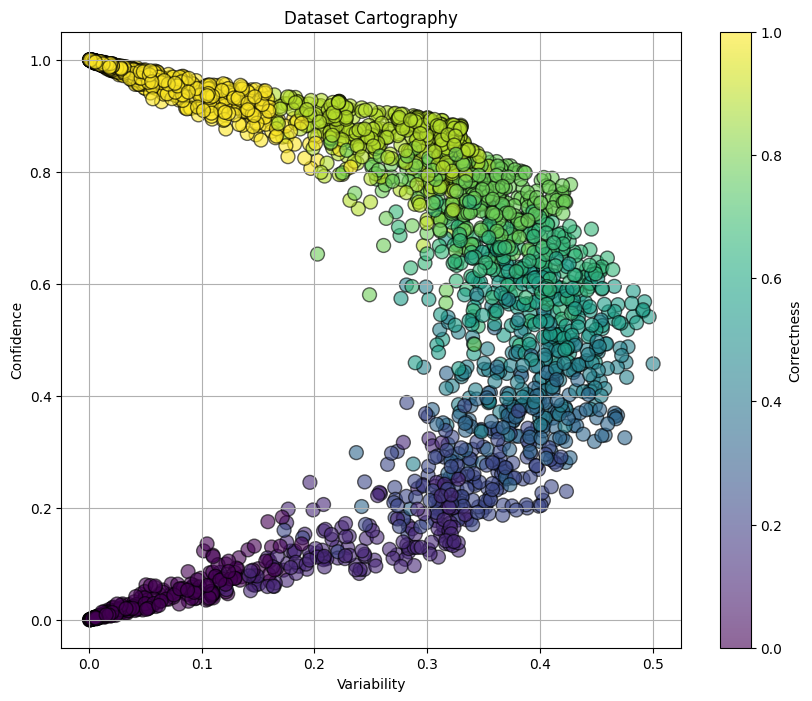

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data
data = {
    'variability': variability,
    'confidence': confidence,
    'correctness': correctness
}

df = pd.DataFrame(data)

# Create the scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df['variability'], df['confidence'], 
                      c=df['correctness'], cmap='viridis', 
                      s=100, alpha=0.6, edgecolor='k')

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Correctness')

# Add labels and title
plt.xlabel('Variability')
plt.ylabel('Confidence')
plt.title('Dataset Cartography')

# Show the plot
plt.grid()
plt.show()

### Soft Voting Classifier

In [101]:
cols = ['Gemma-2-2b-it-probs',
       'Meta-llama-3-70b-instruct-probs', 'Mixtral-8x7b-instruct-v0.1-probs',
       'Gemma-2-9b-it-probs', 'Meta-llama-3.1-70b-instruct-probs',
       'Mistral-7b-instruct-v0.3-probs', 'Phi-3-medium-4k-instruct-probs',
       'Meta-llama-3.1-8b-instruct-probs', 'Meta-llama-3-8b-instruct-probs']
def calculate_mean_std(row, prob_columns = cols):
    actual_index = row['Actual']
    
    # Extract the value at 'actual_index' from each list
    values = [row[col][actual_index] for col in prob_columns]
    
    # Calculate mean and standard deviation
    mean_value = np.mean(values)
    std_value = np.std(values)
    
    return pd.Series({'Mean': mean_value, 'Std': std_value})


In [119]:
csv_dir = './res/test_total/instruct_class_proba'
csv_files = [f for f in os.listdir(csv_dir) if f.endswith('.csv')]

df_combined = pd.DataFrame()

for file in csv_files:
    file_path = os.path.join(csv_dir, file)
    df = pd.read_csv(file_path)
    df = df.drop('Unnamed: 0', axis=1)
    df = df.rename(columns = {df.columns[-1]: df.columns[-1].split('/')[-1]})
    if df_combined.empty:
        df_combined = df
    else:
        df_combined = pd.merge(df_combined, df, on=['id', 'actual'], how='outer')
df_combined.columns = df_combined.columns.str.capitalize()

df_combined_ = df_combined[[col for col in df_combined.columns if not 'probs' in col]]

cols_to_keep = df_combined.columns[:2].tolist() + [col for col in df_combined.columns if 'probs' in col]
df_combined = df_combined[cols_to_keep]

for col in df_combined.columns:
    if 'probs' in col:
        df_combined[col] = df_combined[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

a = df_combined.apply(calculate_mean_std, axis=1)
means, stds = list(a['Mean']), list(a['Std'])
df_combined['Sum_Probs'] = df_combined[[col for col in df_combined.columns if 'probs' in col]].apply(lambda row: [sum(x) for x in zip(*row)], axis=1)

df_combined['best_clssifier'] = df_combined['Meta-llama-3.1-70b-instruct-probs'].apply(lambda x: x.index(max(x)))
df_combined['voting_classif'] = df_combined['Sum_Probs'].apply(lambda x: x.index(max(x)))
corectns = []



In [120]:
for i,j in zip(df_combined['Sum_Probs'], df_combined['Actual']):
    corectns.append(i[j]/9)

In [121]:
print('voting classifier', metrics(list(df_combined['Actual']), list(df_combined['voting_classif'])))
print('best classifier', metrics(list(df_combined['Actual']), list(df_combined['best_clssifier'])))


TypeError: 'list' object is not callable

/var/folders/5_/ct_h64s936q91wl1qyv28l040000gn/T/ipykernel_61056/3089597934.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn')  # Red for incorrect, green for correct


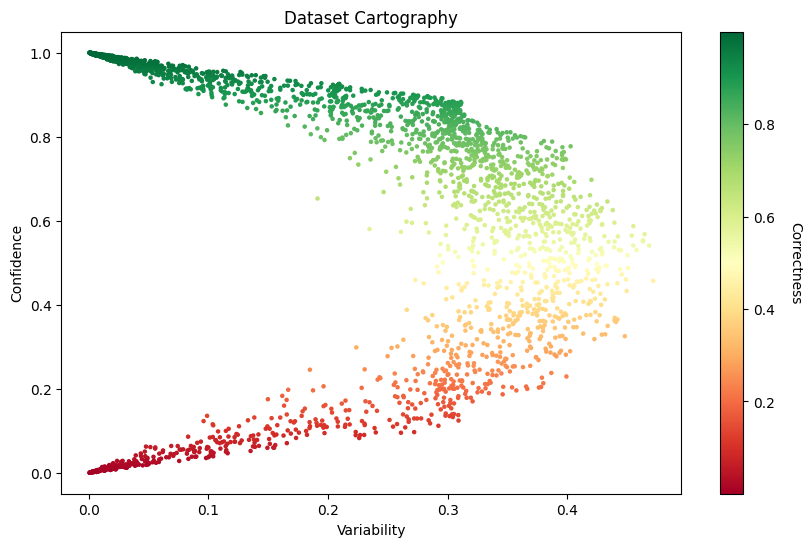

In [125]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with your actual dataset)
variability = stds
confidence = means
correctness = corectns

# Set up color map (adjust to your color preferences)
cmap = plt.cm.get_cmap('RdYlGn')  # Red for incorrect, green for correct

# Create scatter plot
plt.figure(figsize=(10, 6))
sc = plt.scatter(variability, confidence, c=correctness, cmap=cmap, s=5)

# Color bar
cbar = plt.colorbar(sc)
cbar.set_label('Correctness', rotation=270, labelpad=20)

# Labels and title
plt.xlabel('Variability')
plt.ylabel('Confidence')
plt.title('Dataset Cartography')

# Display plot
plt.savefig('./res/carto.pdf', dpi = 300)


All predicted confidences >= actual confidences: True
All predicted confidences >= actual confidences: True


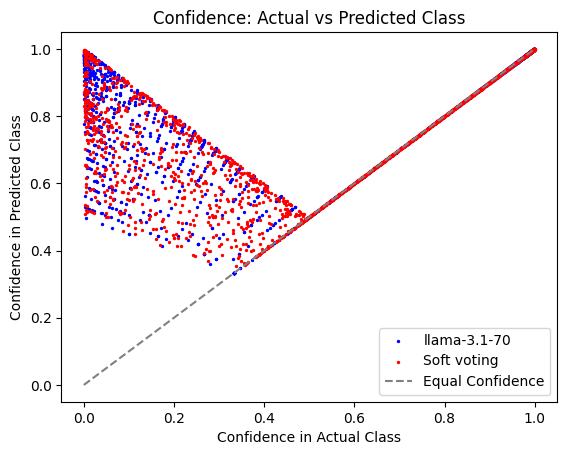

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace this with your actual predictions and labels)
llama70 = list(df_combined['Meta-llama-3.1-70b-instruct-probs'])

sv = list(np.array(list(df_combined['Sum_Probs']))/9)

actual_labels = list(df_combined['Actual'])

# Extract actual and predicted confidences
actual_confidence1 = [llama70[i][actual_labels[i]] for i in range(len(actual_labels))]
predicted_confidence1 = [max(llama70[i]) for i in range(len(llama70))]

actual_confidence2 = [sv[i][actual_labels[i]] for i in range(len(actual_labels))]
predicted_confidence2 = [max(sv[i]) for i in range(len(sv))]

# Check if the predicted confidence >= actual confidence
comparison1 = np.array(predicted_confidence1) >= np.array(actual_confidence1)
print(f"All predicted confidences >= actual confidences: {all(comparison1)}")

comparison2 = np.array(predicted_confidence2) >= np.array(actual_confidence2)
print(f"All predicted confidences >= actual confidences: {all(comparison2)}")

# Create scatter plot
plt.scatter(actual_confidence1, predicted_confidence1, c='blue', label='llama-3.1-70',s = 2)
plt.scatter(actual_confidence2, predicted_confidence2, c='red', label='Soft voting',s = 2)

# Add labels and title
plt.xlabel('Confidence in Actual Class')
plt.ylabel('Confidence in Predicted Class')
plt.title('Confidence: Actual vs Predicted Class')

# Add diagonal line for comparison
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Equal Confidence')

# Show legend
plt.legend()

# Show plot
plt.show()


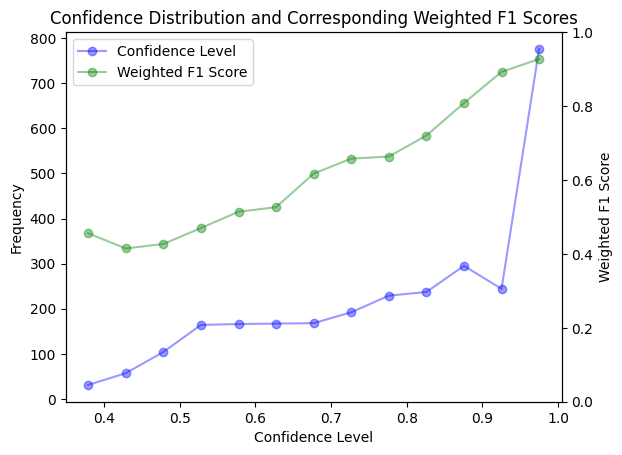

In [128]:
hardness_levels = list(df_combined['Sum_Probs'].apply(lambda x: max(x)/9))
actual_classes = list(df_combined['Actual'])
predicted_classes = list(df_combined['voting_classif'])

counts, bin_edges = np.histogram(hardness_levels, bins=13)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

wf1_scores = []
for i in range(len(bin_edges) - 1):
    bin_indices = [idx for idx, h in enumerate(hardness_levels) if bin_edges[i] <= h < bin_edges[i + 1]]
    
    if bin_indices:
        actual_bin = [actual_classes[idx] for idx in bin_indices]
        predicted_bin = [predicted_classes[idx] for idx in bin_indices]
        
        wf1 = f1_score(actual_bin, predicted_bin, average='weighted')
    else:
        wf1 = 0
    wf1_scores.append(wf1)

fig, ax1 = plt.subplots()

line1 = ax1.plot(bin_centers, counts, marker='o',color='blue', alpha=0.4, label='Confidence Level')
ax1.set_xlabel('Confidence Level')
ax1.set_ylabel('Frequency', color='black')
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()
line2 = ax2.plot(bin_centers, wf1_scores, marker='o',color='green', alpha=0.4, label='Weighted F1 Score')
ax2.set_ylabel('Weighted F1 Score', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim(0, 1) 

plt.title('Confidence Distribution and Corresponding Weighted F1 Scores')
lines = line1 + line2  # Combine both line objects
labels = [l.get_label() for l in lines]  # Get the labels for both lines
plt.legend(lines, labels)
plt.savefig('./res/ff.pdf', dpi = 300)

### other

In [133]:
import pandas as pd

# List of file paths for the 6 CSV files
file_paths = ['./res/opinions/g29i.csv', './res/opinions/g227i.csv', './res/opinions/l3-70bI.csv', './res/opinions/l31-70bI.csv', './res/opinions/p3mi.csv']

# Initialize an empty list to store the dataframes
dfs = []

# Read each CSV file and append to the list
for file in file_paths:
    df = pd.read_csv(file)
    dfs.append(df)

# Merge all the dataframes on the 'id' column
merged_df = dfs[0]
for df in dfs[1:]:
    merged_df = pd.merge(merged_df, df, on='id', suffixes=('', '_dup'))

# Concatenate the opinion columns
merged_df['opinion-support'] = merged_df.filter(like='opinion-support').apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
merged_df['opinion-against'] = merged_df.filter(like='opinion-against').apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
merged_df['opinion-neutral'] = merged_df.filter(like='opinion-neutral').apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

# Drop duplicate opinion columns created during the merge
merged_df = merged_df.loc[:, ~merged_df.columns.str.contains('_dup')]

# Save the merged result to a new CSV file
merged_df.to_csv('merged_output.csv', index=False)

print("Merging completed successfully.")


Merging completed successfully.


In [132]:
merged_df['opinion-support'][0]

'The writer\'s stance is **not** supportive of sending people to a site emergency, as they argue against it by comparing it to the dangers of sending people to an epidemic site and highlighting the potential negative consequences. The writer\'s stance is actually **against** sending people to the site of the emergency, arguing that it would be "madness" to risk spreading the disease further. \n\n\nThe writer uses the analogy of a flu epidemic to highlight the The writer\'s stance is not supportive of sending people site emergency. The writer argues that it would be madness to send people to the site of an emergency epidemic, as they would contract the disease and spread it to others, causing financial disarray, unrest The writer\'s stance is actually not supportive of sending people to the site in an emergency, but rather the opposite. The writer argues that it would be unwise to send people to the site of an epidemic, as it would risk spreading the disease and The writer\'s stance app